In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import jax
import warnings
warnings.filterwarnings("ignore")
import netket.nn as nknn
import flax.linen as nn
import jax.numpy as jnp

In [2]:
#Couplings J1 and J2
J = [1, 0.2]
L = 8

In [3]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])
# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

In [4]:
#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

In [5]:
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)

In [6]:
op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)

In [7]:
class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], 
                     use_bias=True, 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.01), 
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x

model = FFNN()

In [8]:
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)
vs = nk.vqs.MCState(sa, model, n_samples=1008)
opt = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.01)
gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)

In [9]:
vs

MCState(
  hilbert = Spin(s=1/2, total_sz=0.0, N=8),
  sampler = MetropolisSampler(rule = ExchangeRule(# of clusters: 28), n_chains = 16, n_sweeps = 8, reset_chains = False, machine_power = 2, dtype = <class 'float'>),
  n_samples = 1008,
  n_discard_per_chain = 100,
  sampler_state = MetropolisSamplerState(rng state=[ 745857503 2378676913]),
  n_parameters = 144)

In [10]:
vs_i_parameters = vs.parameters.copy()

In [11]:
vs_i_parameters['Dense_0']['bias']

Array([ 8.66538956e-03+0.00016004j, -5.60265878e-03+0.00032698j,
        9.75917360e-03-0.00214929j,  8.40013439e-04-0.00667045j,
       -4.99468042e-05+0.00867812j, -6.73898669e-03+0.00585362j,
        1.06172293e-02+0.00450553j,  1.89256013e-04+0.00511551j,
        1.31336346e-04-0.00015651j, -1.16615586e-02-0.0049068j ,
       -1.51143062e-02+0.00167794j,  3.91553876e-03-0.00357643j,
       -5.41086030e-03-0.0008891j , -1.89802970e-03+0.00750485j,
        3.02255448e-03-0.00213059j, -3.94961147e-04-0.00765898j],      dtype=complex128)

In [12]:
list(vs_i_parameters['Dense_0']['kernel'])[0]

Array([ 0.00289025+0.00769836j,  0.00875608-0.00771527j,
        0.00129545-0.01367895j, -0.00115506+0.00576424j,
        0.00473819+0.01108918j, -0.0044973 -0.00708003j,
       -0.00242377-0.01783566j, -0.00977793+0.00123529j,
       -0.01244302+0.00325376j, -0.00176209-0.01575735j,
        0.00471445+0.00343254j,  0.00024838+0.00431702j,
        0.00353876+0.00576544j, -0.00470166-0.01830768j,
        0.00748658+0.00490173j, -0.01047275-0.00672235j],      dtype=complex128)

In [13]:
# Define a função de perda (loss function) para o treinamento
def loss(params, structure_factor):
    output = model.apply({'params': params}, structure_factor)
    return jnp.mean(output)

In [14]:
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L

In [17]:
# Define uma lista para armazenar os parâmetros do modelo durante o treinamento
trained_params_list = []
parameters_list     = []
it                  = []
# Função de callback para salvar os parâmetros durante o treinamento
def save_params(step, params, energy):
    print((len(it)))
    trained_params_list.append(params.copy())
    parameters_list.append(energy.state.parameters.copy())
    it.append(1)
    print("=====================")          
    return True

In [18]:
gs.run(out='test', n_iter=300, obs={'Structure Factor': structure_factor}, callback=save_params)

  1%|▌                                                                                         | 2/300 [00:00<00:17, 16.92it/s, Energy=-9.96+0.00j ± 0.15 [σ²=23.56, R̂=1.0110]]

0
1
2
3


  2%|█▊                                                                                       | 6/300 [00:00<00:15, 18.77it/s, Energy=-11.62-0.00j ± 0.12 [σ²=14.35, R̂=1.0085]]

4
5
6
7


  3%|██▊                                                                                  | 10/300 [00:00<00:15, 18.63it/s, Energy=-12.382-0.000j ± 0.089 [σ²=8.020, R̂=1.0010]]

8
9
10
11


  5%|███▉                                                                                 | 14/300 [00:00<00:15, 18.14it/s, Energy=-12.878-0.003j ± 0.066 [σ²=4.364, R̂=1.0166]]

12
13
14
15


  6%|█████                                                                                | 18/300 [00:01<00:15, 17.95it/s, Energy=-13.247-0.003j ± 0.043 [σ²=1.837, R̂=1.0203]]

16
17
18
19


  7%|██████▏                                                                              | 22/300 [00:01<00:15, 17.79it/s, Energy=-13.311-0.000j ± 0.032 [σ²=1.063, R̂=1.0183]]

20
21
22
23


  9%|███████▎                                                                             | 26/300 [00:01<00:15, 17.71it/s, Energy=-13.308-0.001j ± 0.024 [σ²=0.604, R̂=1.0212]]

24
25
26
27


 10%|████████▌                                                                            | 30/300 [00:01<00:15, 17.64it/s, Energy=-13.355+0.004j ± 0.020 [σ²=0.399, R̂=1.0106]]

28
29
30
31


 11%|█████████▋                                                                           | 34/300 [00:01<00:15, 17.42it/s, Energy=-13.399+0.003j ± 0.013 [σ²=0.166, R̂=1.0153]]

32
33
34
35


 13%|██████████▊                                                                          | 38/300 [00:02<00:15, 17.17it/s, Energy=-13.376+0.002j ± 0.011 [σ²=0.116, R̂=1.0240]]

36
37
38
39


 14%|███████████▎                                                                     | 42/300 [00:02<00:15, 16.89it/s, Energy=-13.3990-0.0005j ± 0.0074 [σ²=0.0545, R̂=1.0226]]

40
41
42
43


 15%|████████████▍                                                                    | 46/300 [00:02<00:15, 16.88it/s, Energy=-13.3923-0.0006j ± 0.0066 [σ²=0.0435, R̂=1.0147]]

44
45
46
47


 17%|█████████████▌                                                                   | 50/300 [00:02<00:14, 16.95it/s, Energy=-13.4007+0.0001j ± 0.0050 [σ²=0.0253, R̂=1.0142]]

48
49
50
51


 18%|██████████████▌                                                                  | 54/300 [00:03<00:14, 16.84it/s, Energy=-13.4022+0.0020j ± 0.0044 [σ²=0.0192, R̂=1.0108]]

52
53
54
55


 19%|███████████████▋                                                                 | 58/300 [00:03<00:14, 16.86it/s, Energy=-13.3977-0.0025j ± 0.0040 [σ²=0.0163, R̂=1.0066]]

56
57
58
59


 21%|████████████████▋                                                                | 62/300 [00:03<00:14, 16.95it/s, Energy=-13.4002-0.0005j ± 0.0035 [σ²=0.0121, R̂=1.0085]]

60
61
62
63


 22%|█████████████████▊                                                               | 66/300 [00:03<00:13, 16.86it/s, Energy=-13.4014-0.0017j ± 0.0029 [σ²=0.0084, R̂=1.0114]]

64
65
66
67


 23%|██████████████████▉                                                              | 70/300 [00:04<00:13, 16.82it/s, Energy=-13.4016-0.0010j ± 0.0028 [σ²=0.0082, R̂=1.0034]]

68
69
70
71


 25%|███████████████████▉                                                             | 74/300 [00:04<00:13, 16.80it/s, Energy=-13.4010+0.0008j ± 0.0019 [σ²=0.0038, R̂=1.0076]]

72
73
74
75


 26%|█████████████████████                                                            | 78/300 [00:04<00:13, 16.71it/s, Energy=-13.4015+0.0014j ± 0.0022 [σ²=0.0049, R̂=1.0105]]

76
77
78
79


 27%|██████████████████████▏                                                          | 82/300 [00:04<00:13, 16.69it/s, Energy=-13.4035+0.0011j ± 0.0021 [σ²=0.0043, R̂=1.0077]]

80
81
82
83


 29%|███████████████████████▏                                                         | 86/300 [00:05<00:12, 16.87it/s, Energy=-13.4031+0.0017j ± 0.0020 [σ²=0.0041, R̂=1.0085]]

84
85
86
87


 30%|████████████████████████▎                                                        | 90/300 [00:05<00:12, 16.84it/s, Energy=-13.4022+0.0017j ± 0.0022 [σ²=0.0047, R̂=1.0118]]

88
89
90
91


 31%|█████████████████████████▍                                                       | 94/300 [00:05<00:12, 16.74it/s, Energy=-13.4018+0.0025j ± 0.0022 [σ²=0.0048, R̂=1.0105]]

92
93
94
95


 33%|██████████████████████████▍                                                      | 98/300 [00:05<00:12, 16.70it/s, Energy=-13.4032-0.0016j ± 0.0017 [σ²=0.0031, R̂=1.0094]]

96
97
98
99


 34%|███████████████████████████▏                                                    | 102/300 [00:06<00:11, 16.74it/s, Energy=-13.4027+0.0008j ± 0.0015 [σ²=0.0024, R̂=1.0067]]

100
101
102
103


 35%|████████████████████████████▎                                                   | 106/300 [00:06<00:11, 16.69it/s, Energy=-13.4028-0.0006j ± 0.0014 [σ²=0.0019, R̂=1.0109]]

104
105
106
107


 37%|█████████████████████████████▎                                                  | 110/300 [00:06<00:11, 16.63it/s, Energy=-13.4032-0.0000j ± 0.0013 [σ²=0.0018, R̂=1.0035]]

108
109
110
111


 38%|██████████████████████████████▍                                                 | 114/300 [00:06<00:11, 16.67it/s, Energy=-13.4031-0.0002j ± 0.0015 [σ²=0.0021, R̂=1.0091]]

112
113
114
115


 39%|███████████████████████████████▍                                                | 118/300 [00:06<00:10, 16.62it/s, Energy=-13.4013+0.0013j ± 0.0010 [σ²=0.0010, R̂=1.0129]]

116
117
118
119


 41%|████████████████████████████████▌                                               | 122/300 [00:07<00:10, 16.70it/s, Energy=-13.4038-0.0021j ± 0.0015 [σ²=0.0022, R̂=1.0120]]

120
121
122
123


 42%|█████████████████████████████████▌                                              | 126/300 [00:07<00:10, 16.73it/s, Energy=-13.4041-0.0003j ± 0.0012 [σ²=0.0015, R̂=1.0101]]

124
125
126
127


 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:10, 16.83it/s, Energy=-13.4031-0.0003j ± 0.0012 [σ²=0.0014, R̂=1.0054]]

128
129
130
131


 45%|█████████████████████████████████▉                                          | 134/300 [00:07<00:09, 16.89it/s, Energy=-13.40271-0.00077j ± 0.00094 [σ²=0.00089, R̂=1.0122]]

132
133
134
135


 46%|██████████████████████████████████▉                                         | 138/300 [00:08<00:09, 16.73it/s, Energy=-13.40294+0.00089j ± 0.00081 [σ²=0.00066, R̂=1.0058]]

136
137
138
139


 47%|█████████████████████████████████████▊                                          | 142/300 [00:08<00:09, 16.57it/s, Energy=-13.4024+0.0010j ± 0.0011 [σ²=0.0012, R̂=1.0073]]

140
141
142
143


 49%|████████████████████████████████████▉                                       | 146/300 [00:08<00:09, 16.52it/s, Energy=-13.40286+0.00057j ± 0.00078 [σ²=0.00061, R̂=1.0071]]

144
145
146
147


 50%|████████████████████████████████████████                                        | 150/300 [00:08<00:09, 16.61it/s, Energy=-13.3976-0.0012j ± 0.0054 [σ²=0.0298, R̂=1.0088]]

148
149
150
151


 51%|███████████████████████████████████████                                     | 154/300 [00:09<00:08, 16.68it/s, Energy=-13.40241-0.00024j ± 0.00087 [σ²=0.00077, R̂=1.0076]]

152
153
154
155


 53%|████████████████████████████████████████                                    | 158/300 [00:09<00:08, 16.61it/s, Energy=-13.40260+0.00036j ± 0.00085 [σ²=0.00072, R̂=1.0079]]

156
157
158
159


 54%|█████████████████████████████████████████                                   | 162/300 [00:09<00:08, 16.61it/s, Energy=-13.40295+0.00001j ± 0.00094 [σ²=0.00090, R̂=1.0064]]

160
161
162
163


 55%|██████████████████████████████████████████                                  | 166/300 [00:09<00:07, 16.76it/s, Energy=-13.40247+0.00021j ± 0.00063 [σ²=0.00040, R̂=1.0109]]

164
165
166
167


 57%|███████████████████████████████████████████                                 | 170/300 [00:10<00:07, 16.65it/s, Energy=-13.40159+0.00011j ± 0.00070 [σ²=0.00049, R̂=1.0055]]

168
169
170
171


 58%|████████████████████████████████████████████                                | 174/300 [00:10<00:07, 16.61it/s, Energy=-13.40327+0.00013j ± 0.00069 [σ²=0.00048, R̂=1.0085]]

172
173
174
175


 59%|█████████████████████████████████████████████                               | 178/300 [00:10<00:07, 16.62it/s, Energy=-13.40348+0.00032j ± 0.00066 [σ²=0.00044, R̂=1.0049]]

176
177
178
179


 61%|██████████████████████████████████████████████                              | 182/300 [00:10<00:07, 16.65it/s, Energy=-13.40287-0.00059j ± 0.00071 [σ²=0.00050, R̂=1.0048]]

180
181
182
183


 62%|███████████████████████████████████████████████                             | 186/300 [00:11<00:06, 16.57it/s, Energy=-13.40280+0.00032j ± 0.00067 [σ²=0.00045, R̂=1.0075]]

184
185
186
187


 63%|████████████████████████████████████████████████▏                           | 190/300 [00:11<00:06, 16.67it/s, Energy=-13.40288+0.00019j ± 0.00065 [σ²=0.00042, R̂=1.0107]]

188
189
190
191


 65%|█████████████████████████████████████████████████▏                          | 194/300 [00:11<00:06, 16.57it/s, Energy=-13.40285-0.00043j ± 0.00061 [σ²=0.00037, R̂=1.0027]]

192
193
194
195


 66%|██████████████████████████████████████████████████▏                         | 198/300 [00:11<00:06, 16.55it/s, Energy=-13.40325-0.00029j ± 0.00066 [σ²=0.00044, R̂=1.0106]]

196
197
198
199


 67%|███████████████████████████████████████████████████▏                        | 202/300 [00:12<00:05, 16.49it/s, Energy=-13.40252-0.00009j ± 0.00051 [σ²=0.00026, R̂=1.0062]]

200
201
202
203


 69%|████████████████████████████████████████████████████▏                       | 206/300 [00:12<00:05, 16.49it/s, Energy=-13.40351-0.00058j ± 0.00068 [σ²=0.00047, R̂=1.0103]]

204
205
206
207


 70%|█████████████████████████████████████████████████████▏                      | 210/300 [00:12<00:05, 16.44it/s, Energy=-13.40251-0.00028j ± 0.00051 [σ²=0.00027, R̂=1.0105]]

208
209
210
211


 71%|██████████████████████████████████████████████████████▏                     | 214/300 [00:12<00:05, 16.46it/s, Energy=-13.40251-0.00034j ± 0.00042 [σ²=0.00018, R̂=1.0046]]

212
213
214
215


 73%|███████████████████████████████████████████████████████▏                    | 218/300 [00:12<00:04, 16.54it/s, Energy=-13.40251+0.00075j ± 0.00039 [σ²=0.00015, R̂=1.0152]]

216
217
218
219


 74%|████████████████████████████████████████████████████████▏                   | 222/300 [00:13<00:04, 16.64it/s, Energy=-13.40297+0.00004j ± 0.00045 [σ²=0.00021, R̂=1.0052]]

220
221
222
223


 75%|█████████████████████████████████████████████████████████▎                  | 226/300 [00:13<00:04, 16.53it/s, Energy=-13.40253+0.00151j ± 0.00056 [σ²=0.00032, R̂=1.0063]]

224
225
226
227


 77%|██████████████████████████████████████████████████████████▎                 | 230/300 [00:13<00:04, 16.66it/s, Energy=-13.40275+0.00038j ± 0.00035 [σ²=0.00012, R̂=1.0102]]

228
229
230
231


 78%|███████████████████████████████████████████████████████████▎                | 234/300 [00:13<00:03, 16.50it/s, Energy=-13.40305+0.00043j ± 0.00038 [σ²=0.00014, R̂=1.0037]]

232
233
234
235


 79%|████████████████████████████████████████████████████████████▎               | 238/300 [00:14<00:03, 16.60it/s, Energy=-13.40317-0.00007j ± 0.00039 [σ²=0.00016, R̂=1.0072]]

236
237
238
239


 81%|█████████████████████████████████████████████████████████████▎              | 242/300 [00:14<00:03, 16.50it/s, Energy=-13.40289-0.00022j ± 0.00025 [σ²=0.00006, R̂=1.0090]]

240
241
242
243


 82%|██████████████████████████████████████████████████████████████▎             | 246/300 [00:14<00:03, 16.49it/s, Energy=-13.40294-0.00015j ± 0.00028 [σ²=0.00008, R̂=1.0086]]

244
245
246
247


 83%|███████████████████████████████████████████████████████████████▎            | 250/300 [00:14<00:03, 16.55it/s, Energy=-13.40274-0.00001j ± 0.00029 [σ²=0.00008, R̂=1.0112]]

248
249
250
251


 85%|████████████████████████████████████████████████████████████████▎           | 254/300 [00:15<00:02, 16.58it/s, Energy=-13.40319-0.00018j ± 0.00034 [σ²=0.00012, R̂=1.0108]]

252
253
254
255


 86%|█████████████████████████████████████████████████████████████████▎          | 258/300 [00:15<00:02, 16.49it/s, Energy=-13.40287-0.00028j ± 0.00031 [σ²=0.00010, R̂=1.0050]]

256
257
258
259


 87%|██████████████████████████████████████████████████████████████████▎         | 262/300 [00:15<00:02, 16.65it/s, Energy=-13.40309+0.00016j ± 0.00025 [σ²=0.00006, R̂=1.0055]]

260
261
262
263


 89%|███████████████████████████████████████████████████████████████████▍        | 266/300 [00:15<00:02, 16.80it/s, Energy=-13.40270+0.00007j ± 0.00028 [σ²=0.00008, R̂=1.0038]]

264
265
266
267


 90%|████████████████████████████████████████████████████████████████████▍       | 270/300 [00:16<00:01, 16.37it/s, Energy=-13.40282+0.00047j ± 0.00022 [σ²=0.00005, R̂=1.0078]]

268
269
270
271


 91%|█████████████████████████████████████████████████████████████████████▍      | 274/300 [00:16<00:01, 16.37it/s, Energy=-13.40279+0.00013j ± 0.00025 [σ²=0.00007, R̂=1.0097]]

272
273
274
275


 93%|██████████████████████████████████████████████████████████████████████▍     | 278/300 [00:16<00:01, 16.48it/s, Energy=-13.40301-0.00006j ± 0.00025 [σ²=0.00006, R̂=1.0086]]

276
277
278
279


 94%|███████████████████████████████████████████████████████████████████████▍    | 282/300 [00:16<00:01, 16.49it/s, Energy=-13.40306+0.00007j ± 0.00020 [σ²=0.00004, R̂=1.0115]]

280
281
282
283


 95%|████████████████████████████████████████████████████████████████████████▍   | 286/300 [00:17<00:00, 16.51it/s, Energy=-13.40267+0.00036j ± 0.00020 [σ²=0.00004, R̂=1.0111]]

284
285
286
287


 97%|█████████████████████████████████████████████████████████████████████████▍  | 290/300 [00:17<00:00, 16.46it/s, Energy=-13.40317-0.00035j ± 0.00022 [σ²=0.00005, R̂=1.0015]]

288
289
290
291


 98%|██████████████████████████████████████████████████████████████████████████▍ | 294/300 [00:17<00:00, 16.52it/s, Energy=-13.40291-0.00020j ± 0.00019 [σ²=0.00004, R̂=1.0070]]

292
293
294
295


100%|████████████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 16.83it/s, Energy=-13.40305-0.00005j ± 0.00017 [σ²=0.00003, R̂=1.0036]]

296
297
298
299


(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.061174631118774414
   	Params: 0.0017745494842529297,)

In [19]:
vs_i_parameters['Dense_0']['bias']

Array([ 8.66538956e-03+0.00016004j, -5.60265878e-03+0.00032698j,
        9.75917360e-03-0.00214929j,  8.40013439e-04-0.00667045j,
       -4.99468042e-05+0.00867812j, -6.73898669e-03+0.00585362j,
        1.06172293e-02+0.00450553j,  1.89256013e-04+0.00511551j,
        1.31336346e-04-0.00015651j, -1.16615586e-02-0.0049068j ,
       -1.51143062e-02+0.00167794j,  3.91553876e-03-0.00357643j,
       -5.41086030e-03-0.0008891j , -1.89802970e-03+0.00750485j,
        3.02255448e-03-0.00213059j, -3.94961147e-04-0.00765898j],      dtype=complex128)

In [20]:
vs.parameters['Dense_0']['bias']

Array([-9.40711684e-04-0.00549552j, -1.74487756e-03+0.00142195j,
        5.04709482e-03-0.00338252j,  1.64819457e-04-0.00604791j,
       -2.12619401e-03+0.00040721j, -1.50909109e-05+0.00103123j,
        2.10611361e-03+0.00730848j,  2.58720071e-03+0.00451452j,
        2.73797548e-03-0.00022753j, -1.01997834e-03-0.00451897j,
       -1.10995408e-03+0.0019281j , -7.03115211e-04+0.00066915j,
       -2.79503381e-03+0.00309607j, -5.09952701e-04+0.00199976j,
       -8.11375982e-04+0.00219041j, -1.83531258e-04-0.00093661j],      dtype=complex128)

In [21]:
parameters_list[-1]['Dense_0']['bias']

Array([-9.45271876e-04-0.00550649j, -1.74528470e-03+0.00142533j,
        5.05406340e-03-0.00337489j,  1.65976914e-04-0.00605417j,
       -2.14954801e-03+0.00041299j, -2.16601440e-05+0.00103943j,
        2.11172834e-03+0.00731829j,  2.59788513e-03+0.00451714j,
        2.73738399e-03-0.00022982j, -1.02109903e-03-0.00452347j,
       -1.11418038e-03+0.00193187j, -6.93466848e-04+0.00067156j,
       -2.79853323e-03+0.00310355j, -5.17370728e-04+0.00201228j,
       -8.23724828e-04+0.00218711j, -1.80238805e-04-0.00094463j],      dtype=complex128)

In [22]:
list(vs_i_parameters['Dense_0']['kernel'])[0]

Array([ 0.00289025+0.00769836j,  0.00875608-0.00771527j,
        0.00129545-0.01367895j, -0.00115506+0.00576424j,
        0.00473819+0.01108918j, -0.0044973 -0.00708003j,
       -0.00242377-0.01783566j, -0.00977793+0.00123529j,
       -0.01244302+0.00325376j, -0.00176209-0.01575735j,
        0.00471445+0.00343254j,  0.00024838+0.00431702j,
        0.00353876+0.00576544j, -0.00470166-0.01830768j,
        0.00748658+0.00490173j, -0.01047275-0.00672235j],      dtype=complex128)

In [23]:
list(vs.parameters['Dense_0']['kernel'])[0]

Array([-0.06592603+0.05768415j, -0.15715169-0.06504024j,
        0.06907215-0.01444651j, -0.00768067+0.12091313j,
       -0.06533663+0.24265982j, -0.00797673-0.21323621j,
        0.05708728-0.06213527j, -0.17225244+0.07711039j,
       -0.03358482+0.14739928j, -0.0363945 -0.14673343j,
        0.05890271+0.19319571j,  0.03422413+0.12950774j,
        0.08635435+0.03523842j, -0.08351132-0.09345021j,
        0.08141974+0.07807238j, -0.06158199-0.2117745j ],      dtype=complex128)

In [24]:
list(parameters_list[-1]['Dense_0']['kernel'])[0]

Array([-0.06592039+0.05768107j, -0.15715059-0.06502905j,
        0.06907174-0.0144448j , -0.00768049+0.12091189j,
       -0.06535074+0.2426467j , -0.00796067-0.21325602j,
        0.05709025-0.06213081j, -0.17225128+0.07710168j,
       -0.03358661+0.1473904j , -0.03639468-0.14672978j,
        0.05890309+0.19318044j,  0.0342106 +0.12949999j,
        0.08635851+0.03522975j, -0.08351506-0.09344033j,
        0.08141525+0.07808804j, -0.06157442-0.21178726j],      dtype=complex128)

In [25]:
# Load the data from the .log file
import json
data=json.load(open("test.log"))
iters = data['Energy']['iters']
energy=data['Energy']['Mean']['real']
sf=data['Structure Factor']['Mean']['real']

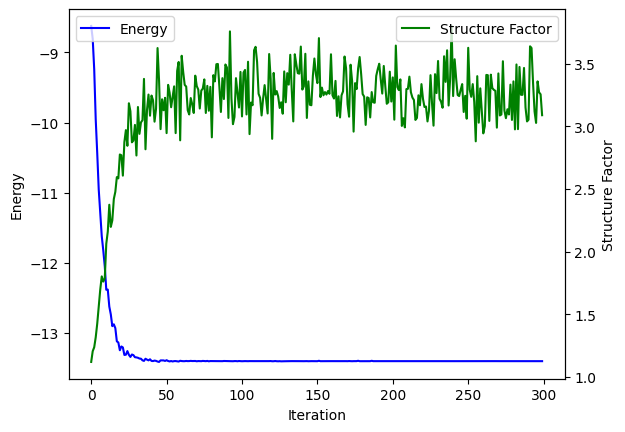

In [26]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color='blue', label='Energy')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax2 = ax1.twinx() 
ax2.plot(iters, np.array(sf), color='green', label='Structure Factor')
ax2.set_ylabel('Structure Factor')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

In [27]:
print(r"Structure factor = {0:.3f}({1:.3f})".format(np.mean(sf[-50:]),
                                              np.std(np.array(sf[-50:]))/np.sqrt(50)))
print(r"Energy = {0:.3f}({1:.3f})".format(np.mean(energy[-50:]), np.std(energy[-50:])/(np.sqrt(50))))

Structure factor = 3.234(0.027)
Energy = -13.403(0.000)


In [28]:
E_gs, ket_gs = nk.exact.lanczos_ed(op, compute_eigenvectors=True)
structure_factor_gs = (ket_gs.T.conj()@structure_factor.to_linear_operator()@ket_gs).real[0,0]

In [29]:
            print("Exact Ground-state Structure Factor: {0:.3f}".format(structure_factor_gs))
print("Exact ground state energy = {0:.3f}".format(E_gs[0]))

Exact Ground-state Structure Factor: 3.284
Exact ground state energy = -13.403
